In [51]:
import cv2
import commonfunctions as cf
import numpy as np
import matplotlib.pyplot as plt
%run count_rows.ipynb

In [52]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
# Load the image
def get_letters(img, show_trace = False):
    # convert to grayscale
    if(show_trace):
        cf.show_images([img],['img'])
    h,w = img.shape
    
    
    tolerance = 0.01 * w 
    # Find the contours
    contours,_ = cv2.findContours(img, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    
    # only keep the contours that are black 
    contours = list(filter(lambda cnt: cv2.contourArea(cnt,True) > 0 , contours))
    
    # sort contours from left to right
    contours = sorted(contours, key=lambda ctr: cv2.boundingRect(ctr)[0])
    contours_list = [(x,y,w,h) for x,y,w,h in [cv2.boundingRect(c) for c in contours]]

    # put masks on the image to get the each letter individually
    masks = []
    for cont in contours:
        mask = np.zeros(img.shape, np.float32)
        cv2.drawContours(mask, [cont], 0, (1,1,1),-1)
        masks.append(mask)
        
    #sort contours from left to right
    # contours_list = sorted(contours_list, key=lambda ctr: ctr[0])


    # merge list that are too close in x axis
    
    def union(a,b):
        '''
        union of two BoxRectangles 
        '''
        x = min(a[0], b[0])
        y = min(a[1], b[1])
        w = max(a[0]+a[2], b[0]+b[2]) - x
        h = max(a[1]+a[3], b[1]+b[3]) - y
        return (x, y, w, h)

    for ind,(x,y,w,h) in enumerate(contours_list):
        prev_x = float('-inf') if ind == 0 else contours_list[ind-1][0]   
        if x - prev_x < tolerance:
            # merge contours 
            contours_list[ind] = union(contours_list[ind],contours_list[ind-1])
            contours_list.pop(ind-1)
            # merge masks of the letters
            masks[ind] = masks[ind] + masks[ind-1]
            masks.pop(ind-1)
            ind -=1
            
    if(show_trace):
        cf.show_images(masks)
    # For each contour, find the bounding rectangle and draw it
    ret_images = []
    for ind,(x,y,w,h) in enumerate(contours_list):
        new_img  = np.logical_and( ~img, masks[ind])[y:y+h,x:x+w].astype(np.uint8)
        ret_images.append(new_img)
        cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),1) #crop 
        cv2.putText(img, str(ind), (x,y), cv2.FONT_ITALIC, 1, (0,0,255), 2, cv2.LINE_AA)
    
    
    if(show_trace):
        cf.show_images(ret_images)
        plt.imshow(img)
        plt.show()
        
        
    for i in range(len(ret_images)):
        ret_images[i] = cv2.resize(ret_images[i], [30,40])
        
    if(show_trace):
        cf.show_images(ret_images)
        
    return ret_images
    

# img =  cv2.cvtColor(cv2.imread('test_images/4.png'), cv2.COLOR_BGR2GRAY)
# get_letters(img, show_trace = True);

1


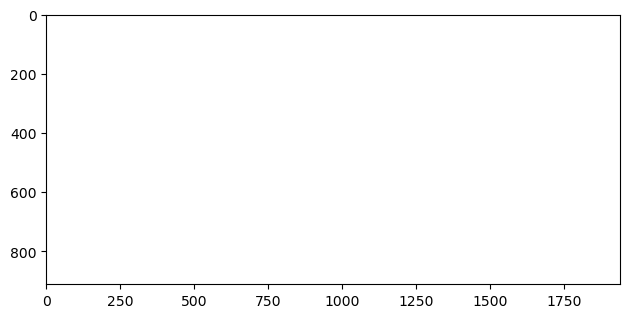

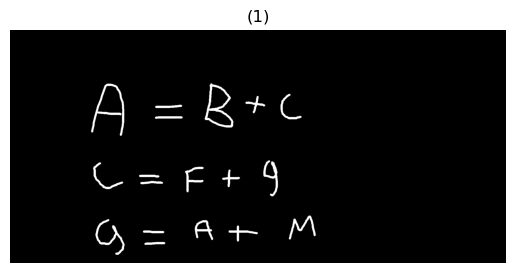

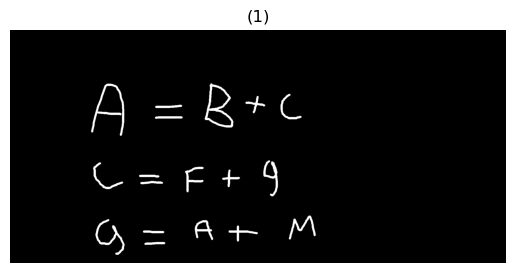

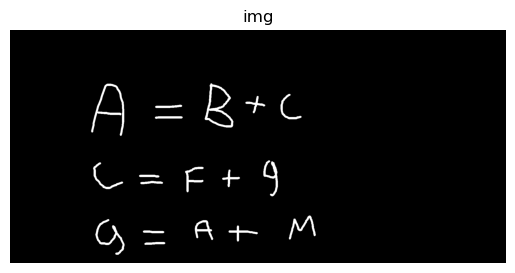

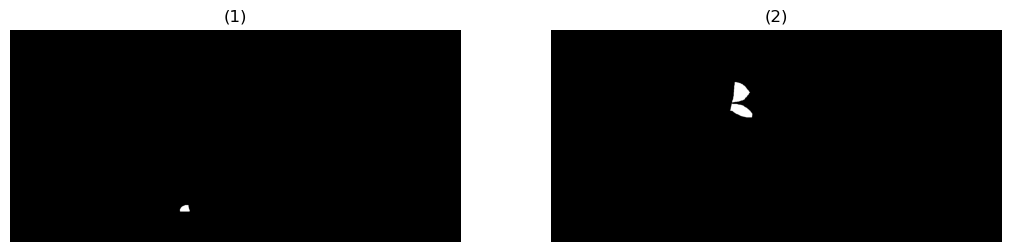

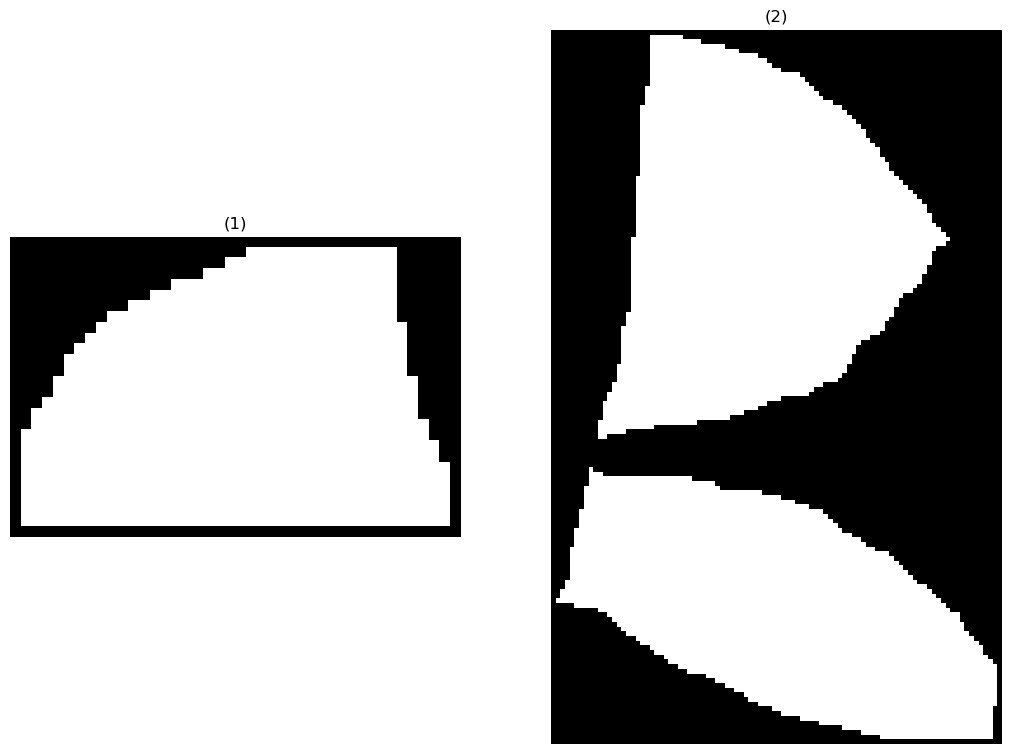

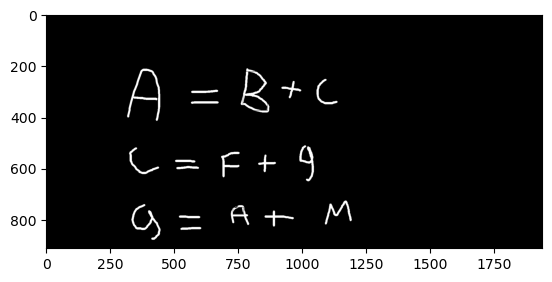

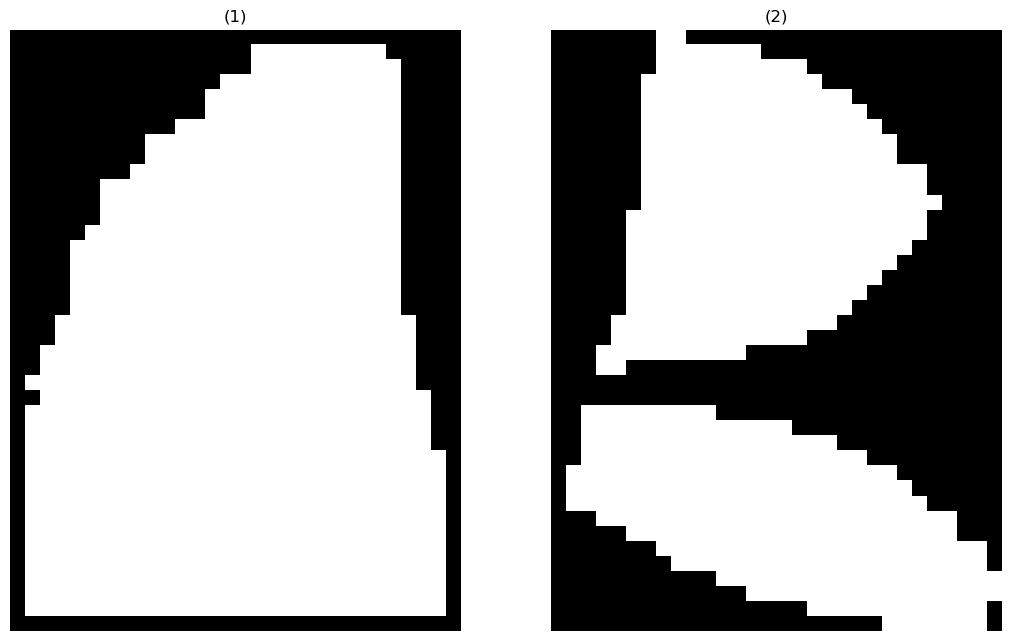

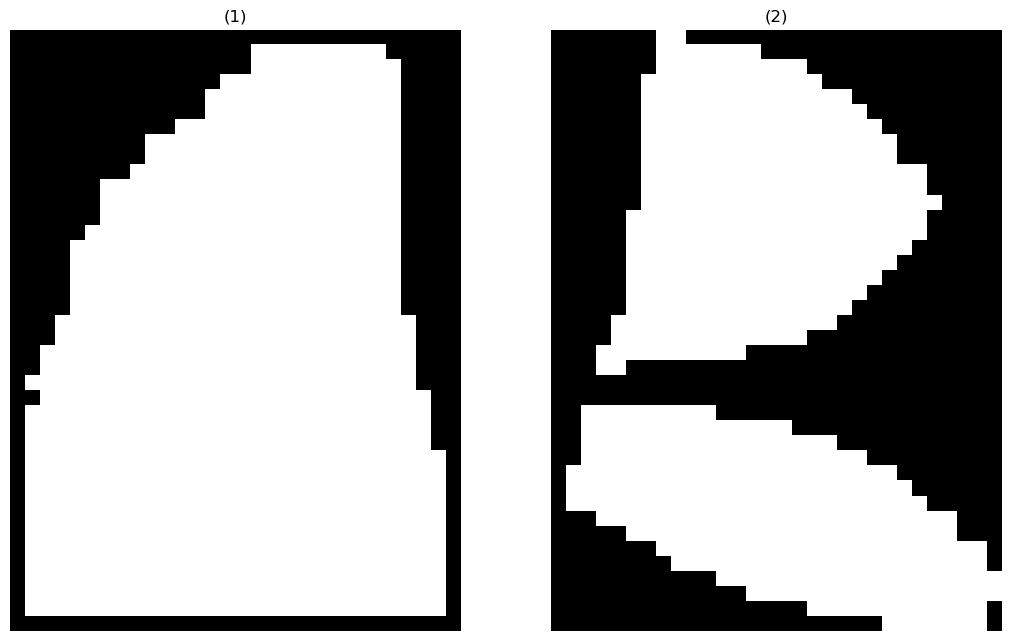

In [67]:
img2 = cf.io.imread('./test_images/3_lines.png') 
img2 =  cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY) 

_,img2 = cv2.threshold(img2,127,255,cv2.THRESH_BINARY)
result2= count_rows(img2)
cf.show_images(result2)
for row in result2:
    # row= cv2.cvtColor(row, cv2.COLOR_BGR2GRAY)
    
    cf.show_images(get_letters(row, show_trace = True)) 
    
